# NQ version 0

In [3]:
import ast
import collections
import json
import math
import os
import re
import statistics
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from dotenv import find_dotenv, load_dotenv
from infomap import Infomap
from networkx.algorithms.cuts import conductance

## Generate Dataframe

In [2]:
# --------------------------------------
#               Load nodes
# --------------------------------------
with open("../data/v0.0/nodes.json", "r", encoding="utf-8-sig") as f:
    data = json.load(f)
nodes = pd.json_normalize(data, sep="_")
nodes = nodes.rename(columns={"d_identity": "id"})
nodes = nodes.drop(columns=["d_labels", "d_properties_document_url", "d_elementId"])

# --------------------------------------
#               Load edges
# --------------------------------------
with open("../data/v0.0/edges.json", "r", encoding="utf-8-sig") as f:
    edges = json.load(f)
edges = pd.DataFrame(edges)

# Group end_ids by start_id → list of citations
citations = edges.groupby("start_id")["end_id"].apply(list).reset_index()

# Merge back onto nodes
nodes = nodes.merge(citations, left_on="id", right_on="start_id", how="left").drop(columns="start_id")

# Rename
nodes = nodes.rename(columns={"end_id": "cites_ids"})

In [3]:
nodes

,id,d_properties_document_title,d_properties_title_encode,cites_ids
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ..."
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156..."
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1..."
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,..."
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123..."
...,...,...,...,...
108066,109707,General Santos,General_Santos,"[46202, 41843, 11243, 6589, 71285, 65890, 1001..."
108067,109708,Hampstead tube station,Hampstead_tube_station,"[8148, 88800, 56419, 46202, 78494, 19161, 6452..."
108068,109709,Kalawa Jazmee Records,Kalawa_Jazmee_Records,"[36441, 20515, 45586, 74759, 93432]"
108069,109710,The Conjuring Universe,The_Conjuring_Universe,"[57062, 56791, 3740, 24991, 23435, 50777, 2708..."


In [4]:
def fix_empty(val):
    # If it's already a list or numpy array, leave it as is
    if isinstance(val, (list, np.ndarray)):
        return val
    # If it's NaN
    if pd.isna(val):
        return []
    # If it's an empty string
    if isinstance(val, str) and val.strip() == "":
        return []
    # Anything else: wrap into list if you want consistent list type
    return val

nodes['cites_ids'] = nodes['cites_ids'].apply(fix_empty)


In [5]:
# Show the dtype of the column
print("dtype of cites_ids column:", nodes["cites_ids"].dtype)

# Show unique python types inside
print("\nPython types inside cites_ids column:")
print(nodes["cites_ids"].map(type).value_counts())

# Peek at first few entries
print("\nSample values from cites_ids column:")
print(nodes["cites_ids"].head(10).to_list())


dtype of cites_ids column: object

Python types inside cites_ids column:
cites_ids
<class 'list'>    108071
Name: count, dtype: int64

Sample values from cites_ids column:
[[6352, 2622, 5393, 3079, 15650, 33906, 13375, 17089, 21278, 40756, 23630, 31751, 36732, 29709, 39868, 19801, 16597, 28821, 10527, 29686, 26683, 10124, 42686, 21384, 16399, 32515], [4286, 4215, 2819, 864, 5115, 3220, 21000, 15635, 36339, 39458, 36232, 37164, 13218, 34315, 10642, 38456, 32515], [6341, 1832, 360, 1739, 4108, 138, 73, 1941, 11040, 7806, 16267, 14147, 19876, 15503, 21518, 14901, 9382, 12414, 15871, 10678, 16911, 9689, 17058, 23502, 24300, 35930, 28182, 37061, 37547, 28817, 33581, 34295, 27989, 30401, 31104, 35910, 31323, 43149, 29714, 41337, 31921, 51113, 79389, 73560, 57142, 58699, 60469, 61321, 65038, 67125, 72121, 64072, 47669, 52625, 59711, 47429, 63753, 67700, 72900, 59757, 84065, 87429, 2912, 55228, 91393, 93432, 96146, 95590], [547, 1646, 3958, 423, 9518, 8998, 9020, 8938, 17568, 18321, 13056, 164

In [5]:
nodes.to_csv("../data/v0.0/df_nq_version0.csv", index=False)

## Summary

In [6]:
n = 15  # top N to display

# ======================================
# Out-degree: how many citations each article makes
# ======================================
nodes["cites_len"] = nodes["cites_ids"].str.len().fillna(0).astype(int)
out_degree = nodes.set_index("id")["cites_len"]

top_citers = (
    nodes.nlargest(n, "cites_len")
    [["id", "d_properties_document_title", "cites_len"]]
)

# ======================================
# In-degree: how many times each article is cited
# ======================================
all_cited = pd.Series([cid for ids in nodes["cites_ids"].dropna() for cid in ids])
cited_counts = all_cited.value_counts().reset_index()
cited_counts.columns = ["id", "cited_count"]

in_degree = cited_counts.set_index("id")["cited_count"].reindex(nodes["id"], fill_value=0)

top_cited = (
    cited_counts.merge(
        nodes[["id", "d_properties_document_title"]],
        on="id", how="left"
    )
    .nlargest(n, "cited_count")
)

# ======================================
# Isolated papers: neither cite nor cited
# ======================================
no_out = nodes.loc[nodes["cites_len"] == 0, ["id", "d_properties_document_title"]]
not_cited_ids = in_degree[in_degree == 0].index
not_cited = nodes[nodes["id"].isin(not_cited_ids)][["id", "d_properties_document_title"]]

isolated_ids = set(no_out["id"]).intersection(not_cited_ids)
isolated = nodes[nodes["id"].isin(isolated_ids)][["id", "d_properties_document_title"]]

# ======================================
# Summary statistics
# ======================================
print("=== NQ v0.0 Summary ===")
print(f"- Total papers: {len(nodes)}")
print(f"- Total citation links: {len(all_cited)}\n")

print("Out-degree (citations made):")
print(f"  • Mean:   {out_degree.mean():.2f}")
print(f"  • Median: {out_degree.median():.2f}")
print(f"  • Max:    {out_degree.max()}")
print(f"  • Min:    {out_degree.min()}\n")

print("In-degree (citations received):")
print(f"  • Mean:   {in_degree.mean():.2f}")
print(f"  • Median: {in_degree.median():.2f}")
print(f"  • Max:    {in_degree.max()}")
print(f"  • Min:    {in_degree.min()}\n")

print("Isolated articles:")
print(f"  • Do not cite others: {len(no_out)}")
print(f"  • Not cited by others: {len(not_cited)}")
print(f"  • Neither cite nor cited: {len(isolated)}")


=== NQ v0.0 Summary ===
- Total papers: 108071
- Total citation links: 5122983

Out-degree (citations made):
  • Mean:   47.40
  • Median: 28.00
  • Max:    1394
  • Min:    0

In-degree (citations received):
  • Mean:   47.40
  • Median: 14.00
  • Max:    46388
  • Min:    0

Isolated articles:
  • Do not cite others: 969
  • Not cited by others: 11989
  • Neither cite nor cited: 535


In [7]:
isolated

,id,d_properties_document_title
321,429,LM317
463,607,I'll Sleep When I'm Dead
1632,2091,Category:Local Government Areas in Rivers State
5307,6948,Category:Drink companies of the Philippines
5476,7117,CoCo (O.T. Genasis song)
...,...,...
89490,91131,Brantley
89642,91283,Dum Dums (lollipop)
89654,91295,Los Topos
90543,92184,Category:Women mayors of places in New Zealand


In [8]:
top_citers

,id,d_properties_document_title,cites_len
3954,5115,United States,1394
57736,59377,Timeline of United States history,1153
4280,5565,List of performances on Top of the Pops,998
15930,17571,2017 in film,998
3738,4831,Southern United States,912
4314,5613,History of the United States,881
13015,14656,New England,856
21335,22976,List of Latin phrases (full),843
24096,25737,California,837
6700,8341,United Kingdom,829


In [9]:
top_cited

,id,cited_count,d_properties_document_title
0,32515,46388,International Standard Book Number
1,93432,46163,"Wikipedia, the free encyclopedia"
2,5115,18735,United States
3,63708,15092,Digital object identifier
4,19755,14851,IMDb
5,10883,10507,Library of Congress Control Number
6,8341,10077,United Kingdom
7,21518,8936,The New York Times
8,17568,7564,Single (music)
9,46202,7536,Geographic coordinate system


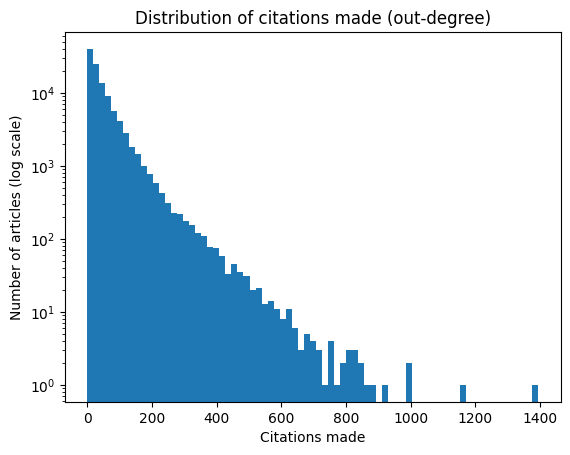

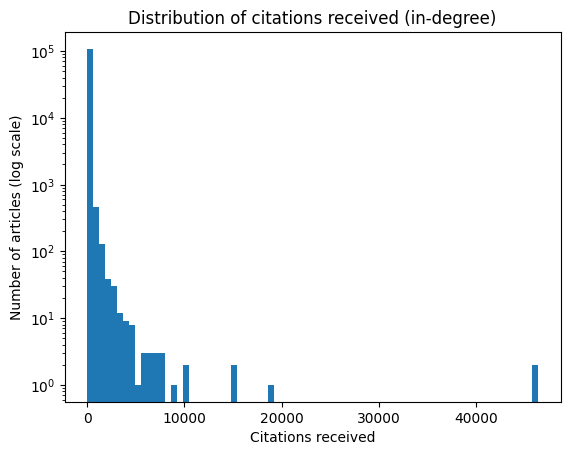

In [10]:
plt.hist(out_degree, bins=75, log=True)
plt.title("Distribution of citations made (out-degree)")
plt.xlabel("Citations made")
plt.ylabel("Number of articles (log scale)")
plt.show()

plt.hist(in_degree, bins=75, log=True)
plt.title("Distribution of citations received (in-degree)")
plt.xlabel("Citations received")
plt.ylabel("Number of articles (log scale)")
plt.show()


## Graph

In [4]:
def create_test_graph(df):
    # Convert stringified lists into real Python lists
    df["cites_ids"] = df["cites_ids"].apply(ast.literal_eval)

    # Create a directed graph
    G = nx.DiGraph()

    for _, row in df.iterrows():
        src = row["id"]
        G.add_node(src, title=row["d_properties_document_title"])
        for tgt in row["cites_ids"]:
            G.add_edge(src, tgt)

    return G

G = create_test_graph(pd.read_csv("../data/v0.0/df_nq_version0.csv"))
print("Graph created with nodes:", G.number_of_nodes(), "and edges:", G.number_of_edges())

# Export graph to GEXF for Gephi analysis
# nx.write_gexf(G, "../data/v0.0/nq_citation_graph_v0.gexf")

Graph created with nodes: 108071 and edges: 5122983


In [ ]:
# Import graph from GEXF file
G = nx.read_gexf("../data/v0.0/nq_citation_graph_v0.gexf")
print("Graph loaded with nodes:", G.number_of_nodes(), "and edges:", G.number_of_edges())

In [2]:
# Build a DIRECTED graph for example
G_teste = nx.LFR_benchmark_graph(
        n=250, tau1=3, tau2=1.5, mu=0.1,
        average_degree=5, min_community=20,
        seed=42
    )
G_teste = nx.DiGraph(G_teste)

In [3]:
def analyze_graph(G, threshold=10000, compute_advanced_metrics=True, remove_isolated=True, print_results=True):
    """
    Comprehensive analysis of graph properties and metrics.
    
    Parameters:
    -----------
    G : networkx.Graph or networkx.DiGraph
        The graph to analyze
    threshold : int, default=10000
        Node count threshold to decide whether to compute expensive metrics
    compute_advanced_metrics : bool, default=True
        Whether to compute computationally expensive metrics
    remove_isolated : bool, default=True
        Whether to remove isolated nodes before analysis
    print_results : bool, default=True
        Whether to print results (otherwise just returns the metrics dict)
        
    Returns:
    --------
    dict
        Dictionary containing all computed metrics
    """
    results = {}
    
    # Basic properties
    results["is_directed"] = G.is_directed()
    results["is_weighted"] = nx.is_weighted(G)
    results["is_multigraph"] = G.is_multigraph()
    
    # Make a copy to avoid modifying the original graph
    if remove_isolated:
        G = G.copy()
    
    # Connectivity analysis
    G_undirected = G.to_undirected()
    results["is_connected_undirected"] = nx.is_connected(G_undirected)
    
    if G.is_directed():
        results["is_strongly_connected"] = nx.is_strongly_connected(G)
        results["is_weakly_connected"] = nx.is_weakly_connected(G)
        results["num_weakly_connected_components"] = nx.number_weakly_connected_components(G)
        results["num_strongly_connected_components"] = nx.number_strongly_connected_components(G)
        
        # Get sizes of components
        weak_components = list(nx.weakly_connected_components(G))
        strong_components = list(nx.strongly_connected_components(G))
        
        results["largest_weakly_connected_component_size"] = len(max(weak_components, key=len))
        results["largest_strongly_connected_component_size"] = len(max(strong_components, key=len))
        
        # Component size statistics
        weak_comp_sizes = [len(c) for c in weak_components]
        strong_comp_sizes = [len(c) for c in strong_components]
        
        results["weakly_connected_component_sizes"] = weak_comp_sizes
        results["strongly_connected_component_sizes"] = strong_comp_sizes
        
        # Calculate component size distribution stats
        results["weakly_cc_size_mean"] = np.mean(weak_comp_sizes)
        results["weakly_cc_size_median"] = np.median(weak_comp_sizes)
        results["strongly_cc_size_mean"] = np.mean(strong_comp_sizes)
        results["strongly_cc_size_median"] = np.median(strong_comp_sizes)
    else:
        # For undirected graphs
        components = list(nx.connected_components(G))
        results["num_connected_components"] = len(components)
        results["largest_connected_component_size"] = len(max(components, key=len))
        results["connected_component_sizes"] = [len(c) for c in components]
        
        # Calculate component size distribution stats
        comp_sizes = [len(c) for c in components]
        results["cc_size_mean"] = np.mean(comp_sizes)
        results["cc_size_median"] = np.median(comp_sizes)
    
    # Node-level statistics
    results["num_nodes"] = G.number_of_nodes()
    results["num_edges"] = G.number_of_edges()
    
    if G.is_directed():
        results["num_nodes_zero_in_degree"] = len([n for n, d in G.in_degree() if d == 0])
        results["num_nodes_zero_out_degree"] = len([n for n, d in G.out_degree() if d == 0])
    
    results["num_nodes_zero_total_degree"] = len([n for n, d in G.degree() if d == 0])
    
    # Remove isolated nodes if requested
    if remove_isolated and results["num_nodes_zero_total_degree"] > 0:
        isolated_nodes = [n for n, d in G.degree() if d == 0]
        G.remove_nodes_from(isolated_nodes)
        results["num_isolated_nodes_removed"] = len(isolated_nodes)
        results["num_nodes_after_removal"] = G.number_of_nodes()
        results["num_edges_after_removal"] = G.number_of_edges()
    
    # Trivial graph statistics
    results["average_degree"] = statistics.mean([d for _, d in G.degree()]) if G.number_of_nodes() > 0 else 0
    results["density"] = nx.density(G)
    results["self_loops"] = nx.number_of_selfloops(G)
    
    if G.is_directed():
        try:
            results["reciprocity"] = nx.reciprocity(G)
        except:
            results["reciprocity"] = None
    
    # Degree statistics
    all_degrees = [d for _, d in G.degree()]
    results["max_degree"] = max(all_degrees) if all_degrees else 0
    results["min_degree"] = min(all_degrees) if all_degrees else 0
    results["median_degree"] = statistics.median(all_degrees) if all_degrees else 0
    results["std_dev_degree"] = statistics.stdev(all_degrees) if len(all_degrees) > 1 else 0
    
    if G.is_directed():
        in_degrees = [d for _, d in G.in_degree()]
        out_degrees = [d for _, d in G.out_degree()]
        
        results["max_in_degree"] = max(in_degrees) if in_degrees else 0
        results["min_in_degree"] = min(in_degrees) if in_degrees else 0
        results["mean_in_degree"] = statistics.mean(in_degrees) if in_degrees else 0
        results["median_in_degree"] = statistics.median(in_degrees) if in_degrees else 0
        
        results["max_out_degree"] = max(out_degrees) if out_degrees else 0
        results["min_out_degree"] = min(out_degrees) if out_degrees else 0
        results["mean_out_degree"] = statistics.mean(out_degrees) if out_degrees else 0
        results["median_out_degree"] = statistics.median(out_degrees) if out_degrees else 0
    
    # Advanced metrics (computationally expensive)
    if compute_advanced_metrics:
        # Transitivity and clustering
        results["transitivity"] = nx.transitivity(G)
        results["average_clustering"] = nx.average_clustering(G)

        # Filtered average clustering (only nodes with degree > 1)
        all_cc = list(nx.clustering(G).values())
        cc_list = []
        for i, x in enumerate(all_degrees):
            if x > 1:
                cc_list.append(all_cc[i])
        results["filtered_average_clustering"] = statistics.mean(cc_list) if cc_list else 0

        # For connected graphs or largest component
        if results.get("is_connected_undirected", False):
            try:
                results["average_shortest_path_length"] = nx.average_shortest_path_length(G_undirected)
                results["diameter"] = nx.diameter(G_undirected)
                results["radius"] = nx.radius(G_undirected)
            except nx.NetworkXError:
                # Handle disconnected graphs - use largest component
                pass
        
        # Get largest connected component for disconnected graphs
        if not results.get("is_connected_undirected", False):
            largest_cc = max(nx.connected_components(G_undirected), key=len)
            largest_cc_graph = G_undirected.subgraph(largest_cc).copy()
            results["largest_cc_size"] = len(largest_cc)
            results["largest_cc_fraction"] = len(largest_cc) / G.number_of_nodes()
            
            try:
                results["largest_cc_average_shortest_path_length"] = nx.average_shortest_path_length(largest_cc_graph)
                results["largest_cc_diameter"] = nx.diameter(largest_cc_graph)
                results["largest_cc_radius"] = nx.radius(largest_cc_graph)
            except:
                # Handle errors in case of very large components
                pass
        
        # Centrality measures - use threshold to avoid memory issues
        node_count = G.number_of_nodes()
        if node_count <= threshold:  # Adjust threshold based on available memory
            try:
                results["average_degree_centrality"] = np.mean(list(dict(nx.degree_centrality(G)).values()))
            except:
                pass
                
            try:
                results["average_closeness_centrality"] = np.mean(list(dict(nx.closeness_centrality(G)).values()))
            except:
                pass
            
            if node_count <= threshold/10:  # Betweenness is very expensive
                try:
                    results["average_betweenness_centrality"] = np.mean(list(dict(nx.betweenness_centrality(G, 
                                                                                 normalized=True, 
                                                                                 k=min(500, node_count))).values()))
                except:
                    pass
                
                # Eigenvector centrality
                try:
                    results["average_eigenvector_centrality"] = np.mean(list(dict(nx.eigenvector_centrality(
                        G, max_iter=100, tol=1e-4)).values()))
                except:
                    results["average_eigenvector_centrality"] = "Failed to converge"
            
            # PageRank for directed graphs
            if G.is_directed() and node_count <= threshold:
                try:
                    pagerank = nx.pagerank(G, alpha=0.85)
                    results["average_pagerank"] = np.mean(list(pagerank.values()))
                    results["max_pagerank"] = max(pagerank.values())
                except:
                    pass
        
        # Additional metrics
        # Bridges (edges that would increase number of connected components if removed)
        if not G.is_directed():
            try:
                results["num_bridges"] = len(list(nx.bridges(G)))
            except:
                pass
        
        # Assortativity - do nodes connect to similar degree nodes?
        try:
            results["degree_assortativity"] = nx.degree_assortativity_coefficient(G)
        except:
            results["degree_assortativity"] = None
        
        # Core decomposition - find k-cores (subgraphs where all nodes have degree >= k)
        # Create a copy without self-loops for core number calculation
        if nx.number_of_selfloops(G) > 0:
            G_no_loops = G.copy()
            G_no_loops.remove_edges_from(nx.selfloop_edges(G_no_loops))
            core_graph = G_no_loops.to_undirected()
        else:
            core_graph = G_undirected
            
        try:
            core_numbers = nx.core_number(core_graph)
            results["max_core_number"] = max(core_numbers.values()) if core_numbers else 0
            results["mean_core_number"] = np.mean(list(core_numbers.values()))
        except:
            pass
        
        # Rich club coefficient - tendency of high-degree nodes to connect to each other
        if not G.is_directed() and node_count <= threshold/2:
            try:
                k = max(5, int(np.percentile([d for _, d in G.degree()], 90)))  # 90th percentile degree
                results["rich_club_coefficient"] = nx.rich_club_coefficient(G, normalized=False).get(k, None)
            except:
                results["rich_club_coefficient"] = None
            
        # Efficiency measures
        if node_count <= threshold/2:
            try:
                results["global_efficiency"] = nx.global_efficiency(G_undirected)
            except:
                pass
    
    # Print results if requested
    if print_results:
        print("\n===== Basic Graph Properties =====")
        print(f" • Is directed..............................: {results['is_directed']}")   
        print(f" • Is weighted..............................: {results['is_weighted']}")  
        print(f" • Is multi-graph...........................: {results['is_multigraph']}")
        print(f" • Is connected (undirected view)...........: {results['is_connected_undirected']}")
        
        if G.is_directed():
            print(f" • Is strongly connected....................: {results['is_strongly_connected']}")
            print(f" • Is weakly connected......................: {results['is_weakly_connected']}")
        
        print("\n===== Node-level Statistics =====")
        print(f" • Number of nodes..........................: {results['num_nodes']}")
        
        if G.is_directed():
            print(f" • Number of nodes with zero in-degree......: {results['num_nodes_zero_in_degree']}")
            print(f" • Number of nodes with zero out-degree.....: {results['num_nodes_zero_out_degree']}")
        
        print(f" • Number of nodes with zero total degree...: {results['num_nodes_zero_total_degree']}")
        
        if remove_isolated and results.get("num_isolated_nodes_removed", 0) > 0:
            print(f"\nRemoved {results['num_isolated_nodes_removed']} isolated nodes")
            print(f" • Nodes after removal.....................: {results['num_nodes_after_removal']}")
            print(f" • Edges after removal.....................: {results['num_edges_after_removal']}")
        
        print("\n===== Global Graph Statistics - Trivial =====")
        print(f" • Number of edges..........................: {results['num_edges']}")
        print(f" • Average degree...........................: {results['average_degree']:.2f}")
        print(f" • Density..................................: {results['density']:.6f}")
        print(f" • Self-loops...............................: {results['self_loops']}")
        
        if G.is_directed():
            print(f" • Reciprocity..............................: {results.get('reciprocity', 'N/A')}")
            print(f" • Number of connected components (weakly)..: {results['num_weakly_connected_components']}")
            print(f" • Number of connected components (strongly): {results['num_strongly_connected_components']}")
            print(f" • Largest weakly connected component size..: {results['largest_weakly_connected_component_size']}")
            print(f" • Largest strongly connected component size: {results['largest_strongly_connected_component_size']}")
            print(f" • Weak component size (mean)...............: {results['weakly_cc_size_mean']:.2f}")
            print(f" • Strong component size (mean).............: {results['strongly_cc_size_mean']:.2f}")
        else:
            print(f" • Number of connected components...........: {results['num_connected_components']}")
            print(f" • Largest connected component size.........: {results['largest_connected_component_size']}")
            print(f" • Component size (mean)....................: {results.get('cc_size_mean', 'N/A')}")
        
        if compute_advanced_metrics:
            print("\n===== Global Graph Statistics - Advanced =====")
            print(f" • Transitivity.............................: {results['transitivity']:.6f}")
            print(f" • Average clustering coefficient...........: {results['average_clustering']:.6f}")
            print(f" • Filtered avg clustering (deg > 1)........: {results['filtered_average_clustering']:.6f}")
            
            if "average_shortest_path_length" in results:
                print(f" • Average distance.........................: {results['average_shortest_path_length']:.4f}")
                print(f" • Diameter.................................: {results['diameter']}")
                print(f" • Radius...................................: {results['radius']}")
            elif "largest_cc_average_shortest_path_length" in results:
                print(" • Graph is disconnected. Metrics for largest connected component:")
                print(f"   - Size...................................: {results['largest_cc_size']} ({results.get('largest_cc_fraction', 0)*100:.1f}% of graph)")
                print(f"   - Average distance.......................: {results.get('largest_cc_average_shortest_path_length', 'N/A')}")
                print(f"   - Diameter...............................: {results.get('largest_cc_diameter', 'N/A')}")
                print(f"   - Radius.................................: {results.get('largest_cc_radius', 'N/A')}")
            
            if "global_efficiency" in results:
                print(f" • Global efficiency........................: {results['global_efficiency']:.6f}")
            
            if "average_degree_centrality" in results:
                print(f" • Average degree centrality................: {results['average_degree_centrality']:.6f}")
            
            if "average_closeness_centrality" in results:
                print(f" • Average closeness centrality.............: {results['average_closeness_centrality']:.6f}")
            
            if "average_betweenness_centrality" in results:
                print(f" • Average betweenness centrality...........: {results['average_betweenness_centrality']:.6f}")
            
            if "average_eigenvector_centrality" in results and results["average_eigenvector_centrality"] != "Failed to converge":
                print(f" • Average eigenvector centrality...........: {results['average_eigenvector_centrality']:.6f}")
            
            if "average_pagerank" in results:
                print(f" • Average PageRank.........................: {results['average_pagerank']:.6f}")
                print(f" • Maximum PageRank.........................: {results['max_pagerank']:.6f}")
            
            if "max_core_number" in results:
                print(f" • Max core number..........................: {results['max_core_number']}")
                if "mean_core_number" in results:
                    print(f" • Mean core number.........................: {results['mean_core_number']:.2f}")
            
            if "num_bridges" in results:
                print(f" • Number of bridges........................: {results['num_bridges']}")
            
            if results.get("degree_assortativity") is not None:
                print(f" • Degree assortativity.....................: {results['degree_assortativity']:.6f}")
            
            if results.get("rich_club_coefficient") is not None:
                print(f" • Rich club coefficient....................: {results['rich_club_coefficient']:.6f}")
    
    return results

In [4]:
# Basic usage with default settings (prints results)
# metrics = analyze_graph(G, threshold=2000000)
metrics = analyze_graph(G_teste)


===== Basic Graph Properties =====
 • Is directed..............................: True
 • Is weighted..............................: False
 • Is multi-graph...........................: False
 • Is connected (undirected view)...........: True
 • Is strongly connected....................: True
 • Is weakly connected......................: True

===== Node-level Statistics =====
 • Number of nodes..........................: 250
 • Number of nodes with zero in-degree......: 0
 • Number of nodes with zero out-degree.....: 0
 • Number of nodes with zero total degree...: 0

===== Global Graph Statistics - Trivial =====
 • Number of edges..........................: 1007
 • Average degree...........................: 8.06
 • Density..................................: 0.016177
 • Self-loops...............................: 19
 • Reciprocity..............................: 0.9811320754716981
 • Number of connected components (weakly)..: 1
 • Number of connected components (strongly): 1
 • Largest we

In [5]:
def analyze_citation_network(G, top_n=10, print_results=True):
    """
    Analyzes a citation network with specialized metrics and visualizations for citation data.
    
    Parameters:
    -----------
    G : networkx.DiGraph
        The citation graph to analyze
    top_n : int, default=10
        Number of top nodes to show in rankings
    print_results : bool, default=True
        Whether to print results
        
    Returns:
    --------
    dict
        Dictionary containing all computed citation metrics
    """
    results = {}
    
    # Basic degree statistics
    out_degrees = [deg for _, deg in G.out_degree()]
    in_degrees = [deg for _, deg in G.in_degree()]
    
    # Summary statistics for citations made (out-degree)
    results["citations_made_mean"] = np.mean(out_degrees)
    results["citations_made_median"] = np.median(out_degrees)
    results["citations_made_max"] = np.max(out_degrees)
    results["citations_made_min"] = np.min(out_degrees)
    results["citations_made_std"] = np.std(out_degrees)
    
    # Summary statistics for citations received (in-degree)
    results["citations_received_mean"] = np.mean(in_degrees)
    results["citations_received_median"] = np.median(in_degrees)
    results["citations_received_max"] = np.max(in_degrees)
    results["citations_received_min"] = np.min(in_degrees)
    results["citations_received_std"] = np.std(in_degrees)
    
    # Top citing nodes (articles that cite the most others)
    out_deg_dict = dict(G.out_degree())
    top_out_nodes = sorted(out_deg_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    results["top_citing_nodes"] = top_out_nodes
    
    # Top cited nodes (articles cited by the most others)
    in_deg_dict = dict(G.in_degree())
    top_in_nodes = sorted(in_deg_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    results["top_cited_nodes"] = top_in_nodes
    
    # Special node categories
    results["num_isolated_nodes"] = len([n for n, d in G.degree() if d == 0])
    results["num_terminal_nodes"] = len([n for n, d in G.out_degree() if d == 0])  # Nodes that don't cite others
    results["num_source_nodes"] = len([n for n, d in G.in_degree() if d == 0])     # Nodes not cited by others
    
    # H-index of the network
    in_degrees_sorted = sorted(in_degrees, reverse=True)
    h_index = 0
    for i, citations in enumerate(in_degrees_sorted):
        if i+1 <= citations:
            h_index = i+1
        else:
            break
    results["h_index"] = h_index
    
    # PageRank - article influence score
    pagerank_scores = nx.pagerank(G, alpha=0.85)
    results["pagerank_top_nodes"] = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    results["pagerank_mean"] = np.mean(list(pagerank_scores.values()))
    
    # Print results if requested
    if print_results:
        print("\n===== Citation Network Analysis =====")
        
        print("\n----- Citation Distribution Statistics -----")
        print("Citations made (out-degree):")
        print(f" • Mean.............: {results['citations_made_mean']:.2f}")
        print(f" • Median...........: {results['citations_made_median']:.1f}")
        print(f" • Max..............: {results['citations_made_max']}")
        print(f" • Min..............: {results['citations_made_min']}")
        print(f" • Std Deviation....: {results['citations_made_std']:.2f}")
        
        print("\nCitations received (in-degree):")
        print(f" • Mean.............: {results['citations_received_mean']:.2f}")
        print(f" • Median...........: {results['citations_received_median']:.1f}")
        print(f" • Max..............: {results['citations_received_max']}")
        print(f" • Min..............: {results['citations_received_min']}")
        print(f" • Std Deviation....: {results['citations_received_std']:.2f}")
        print(f" • Network H-index..: {results['h_index']}")
        
        print("\n----- Node Categories -----")
        print(f" • Isolated nodes (no citations)...: {results['num_isolated_nodes']}")
        print(f" • Terminal nodes (don't cite).....: {results['num_terminal_nodes']}")
        print(f" • Source nodes (not cited)........: {results['num_source_nodes']}")
        
        print("\n----- Top Citing Nodes -----")
        print(f"Top {top_n} nodes that cite the most others:")
        for i, (node, degree) in enumerate(results["top_citing_nodes"], 1):
            node_title = G.nodes[node].get('title', str(node))
            print(f" {i}. {node_title} ({degree} citations made)")
        
        print(f"\n----- Top Cited Nodes -----")
        print(f"Top {top_n} nodes that are cited by the most others:")
        for i, (node, degree) in enumerate(results["top_cited_nodes"], 1):
            node_title = G.nodes[node].get('title', str(node))
            print(f" {i}. {node_title} ({degree} citations received)")
            
        print(f"\n----- Most Influential Nodes (PageRank) -----")
        print(f"Top {top_n} nodes by PageRank score:")
        for i, (node, score) in enumerate(results["pagerank_top_nodes"], 1):
            node_title = G.nodes[node].get('title', str(node))
            print(f" {i}. {node_title} (score: {score:.6f})")
        
    return results

In [6]:
analyze_citation_network(G)


===== Citation Network Analysis =====

----- Citation Distribution Statistics -----
Citations made (out-degree):
 • Mean.............: 47.40
 • Median...........: 28.0
 • Max..............: 1394
 • Min..............: 0
 • Std Deviation....: 59.90

Citations received (in-degree):
 • Mean.............: 47.40
 • Median...........: 14.0
 • Max..............: 46388
 • Min..............: 0
 • Std Deviation....: 268.93
 • Network H-index..: 657

----- Node Categories -----
 • Isolated nodes (no citations)...: 535
 • Terminal nodes (don't cite).....: 969
 • Source nodes (not cited)........: 11989

----- Top Citing Nodes -----
Top 10 nodes that cite the most others:
 1. United States (1394 citations made)
 2. Timeline of United States history (1153 citations made)
 3. 2017 in film (998 citations made)
 4. List of performances on Top of the Pops (998 citations made)
 5. Southern United States (912 citations made)
 6. History of the United States (881 citations made)
 7. New England (856 citatio

{'citations_made_mean': np.float64(47.40386412636138),
 'citations_made_median': np.float64(28.0),
 'citations_made_max': np.int64(1394),
 'citations_made_min': np.int64(0),
 'citations_made_std': np.float64(59.90311682089146),
 'citations_received_mean': np.float64(47.40386412636138),
 'citations_received_median': np.float64(14.0),
 'citations_received_max': np.int64(46388),
 'citations_received_min': np.int64(0),
 'citations_received_std': np.float64(268.9261686468044),
 'top_citing_nodes': [(5115, 1394),
  (59377, 1153),
  (17571, 998),
  (5565, 998),
  (4831, 912),
  (5613, 881),
  (14656, 856),
  (22976, 843),
  (25737, 837),
  (8341, 829)],
 'top_cited_nodes': [(32515, 46388),
  (93432, 46163),
  (5115, 18735),
  (63708, 15092),
  (19755, 14851),
  (10883, 10507),
  (8341, 10077),
  (21518, 8936),
  (17568, 7564),
  (46202, 7536)],
 'num_isolated_nodes': 535,
 'num_terminal_nodes': 969,
 'num_source_nodes': 11989,
 'h_index': 657,
 'pagerank_top_nodes': [(32515, 0.009256632439748

In [ ]:
def degree_list(G):
    return [d_v for (v, d_v) in G.degree()]

all_cc = list(nx.clustering(G).values())
cc_list = []
for i, x in enumerate(degree_list(G)):
    if x > 1:
        cc_list.append(all_cc[i])

statistics.mean(cc_list)

In [ ]:
# Basic graph properties
print("\n===== Basic Graph Properties =====")
print(f" • Is directed..............................: {G.is_directed()}")   
print(f" • Is weighted..............................: {nx.is_weighted(G)}")  
print(f" • Is multi-graph...........................: {G.is_multigraph()}")
is_connected = nx.is_connected(G.to_undirected())
print(f" • Is connected (undirected view)...........: {is_connected}")
print(f" • Is strongly connected....................: {nx.is_strongly_connected(G)}")
print(f" • Is weakly connected......................: {nx.is_weakly_connected(G)}")

# Node-level Statistics
print("\n===== Node-level Statistics =====")
print(f" • Number of nodes with zero in-degree......: {len([n for n, d in G.in_degree() if d == 0])}")
print(f" • Number of nodes with zero out-degree.....: {len([n for n, d in G.out_degree() if d == 0])}")
print(f" • Number of nodes with zero total degree...: {len([n for n, d in G.degree() if d == 0])}")

if not is_connected:
    # Remove isolated nodes (with zero total degree)
    isolated_nodes = [n for n, d in G.degree() if d == 0]
    print("\nRemoving isolated nodes...")
    G.remove_nodes_from(isolated_nodes)
    print(f" • Removed {len(isolated_nodes)} isolated nodes.")

# Trivial graph statistics
print("\n===== Global Graph Statistics - Trivial =====")
print(f" • Number of nodes..........................: {G.number_of_nodes()}")
print(f" • Number of edges..........................: {G.number_of_edges()}")
print(f" • Average degree...........................: {statistics.mean([d_v for (v, d_v) in G.degree()]):.2f}")
print(f" • Density..................................: {nx.density(G):.6f}")
print(f" • Self-loops...............................: {nx.number_of_selfloops(G)}")
print(f" • Reciprocity..............................: {nx.reciprocity(G):.6f}")
print(f" • Number of connected components (weakly)..: {nx.number_weakly_connected_components(G)}")
print(f" • Number of connected components (strongly): {nx.number_strongly_connected_components(G)}")

# Non-trivial graph statistics
print("\n===== Global Graph Statistics - Non-trivial =====")
print(f" • Average distance (approx.)...............: {nx.average_shortest_path_length(G.to_undirected()) if nx.is_connected(G.to_undirected()) else 'Graph is not connected'}")
print(f" • Diameter (approx.).......................: {nx.diameter(G.to_undirected()) if nx.is_connected(G.to_undirected()) else 'Graph is not connected'}")
print(f" • Transitivity.............................: {nx.transitivity(G):.6f}")
print(f" • Average clustering coefficient...........: {nx.average_clustering(G):.6f}")
print(f" • Radius (approx.).........................: {nx.radius(G.to_undirected()) if nx.is_connected(G.to_undirected()) else 'Graph is not connected'}")
print(f" • Average degree centrality................: {np.mean(list(dict(nx.degree_centrality(G)).values())):.6f}")
print(f" • Average closeness centrality.............: {np.mean(list(dict(nx.closeness_centrality(G)).values())):.6f}")
print(f" • Average betweenness centrality...........: {np.mean(list(dict(nx.betweenness_centrality(G)).values())):.6f}")

# Find mean, median, and max size of citations made (out-degree)
out_degrees = [deg for _, deg in G.out_degree()]
mean_out = np.mean(out_degrees)
median_out = np.median(out_degrees)
max_out = np.max(out_degrees)
print(f"\nCitations made (out-degree)\n    • Mean: {mean_out:.2f}\n    • Median: {median_out}\n    • Max: {max_out}")

# Find mean, median, and max size of citations received (in-degree)
in_degrees = [deg for _, deg in G.in_degree()]
mean_in = np.mean(in_degrees)
median_in = np.median(in_degrees)
max_in = np.max(in_degrees)
print(f"\nCitations received (in-degree)\n    • Mean: {mean_in:.2f}\n    • Median: {median_in}\n    • Max: {max_in}")

# Find top 10 node that cites the most other nodes
out_degrees = G.out_degree()
top_10_out_nodes = sorted(out_degrees, key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes that cite the most others:")
for i, (node, degree) in enumerate(top_10_out_nodes, 1):
    print(f" {i}. {G.nodes[node]['title']} ({degree} citations made)")

# Find top 10 node that is cited by the most other nodes
in_degrees = G.in_degree()
top_10_in_nodes = sorted(in_degrees, key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes that are cited by the most others:")
for i, (node, degree) in enumerate(top_10_in_nodes, 1):
    print(f" {i}. {G.nodes[node]['title']} ({degree} citations received)")
